In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LassoCV  # Imported Ridge
import plotly.graph_objs as go
from plotly.offline import plot, init_notebook_mode
import matplotlib.pyplot as plt
init_notebook_mode(connected=True)

In [2]:
# Create the feature matrix X
def create_feature_matrix(data, lags=[1, 2]):
    X = pd.DataFrame()
    for lag in lags:
        for ticker in data.columns:
            X[f'{ticker}_lag_{lag}'] = data[ticker].shift(lag)
    X = X.dropna()
    return X

In [3]:
# Split data into training and testing sets
def split_data(X, y):
    mid_point = len(X) // 2
    X_train, X_test = X[:mid_point], X[mid_point:]
    y_train, y_test = y[:mid_point], y[mid_point:]
    return X_train, X_test, y_train, y_test

In [4]:
# Function to evaluate model for a given number of tickers
def evaluate_model(d, all_data):
    try:
        tickers_used = ticker_list[:d]
        print(f"Evaluating {d} tickers: {tickers_used}")
        data_used = all_data[tickers_used]
        
        # Create the feature matrix using all tickers up to d
        X = create_feature_matrix(data_used)
        y = all_data['GOOGL'][X.index]
        
        print(f"Data used shape: {data_used.shape}")
        print(f"Feature matrix shape: {X.shape}")

        if X.empty or y.empty:
            print(f"Skipping {d} tickers: Empty DataFrame")
            return None  # Skip iteration if the resulting DataFrame is empty
        
        # Adding additional features to X
        new_features = {}
        for ticker in tickers_used:
            if f'{ticker}_lag_1' in X.columns and f'{ticker}_lag_2' in X.columns:
                diff_squared = (X[f'{ticker}_lag_1'] - X[f'{ticker}_lag_2']) ** 2
                volatility = (X[f'{ticker}_lag_1'] - X[f'{ticker}_lag_2']) / X[f'{ticker}_lag_2']
                new_features[f'{ticker}_diff_squared'] = diff_squared
                new_features[f'{ticker}_volatility'] = volatility
        
        if new_features:
            new_features_df = pd.DataFrame(new_features, index=X.index)
            X = pd.concat([X, new_features_df], axis=1)
            X = X.copy()  # Create a de-fragmented copy of the DataFrame

        print(f"Feature matrix after adding new features shape: {X.shape}")

        # Splitting the data
        X_train, X_test, y_train, y_test = split_data(X, y)
        
        print(f"Train/Test split shapes: {X_train.shape}, {X_test.shape}")

        if X_train.empty or y_train.empty or X_test.empty or y_test.empty:
            print(f"Skipping {d} tickers: Empty train/test split")
            return None  # Skip iteration if the split results in empty DataFrames

        # Feature scaling
        scaler_X = StandardScaler().fit(X_train)
        X_train_scaled = scaler_X.transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)

        scaler_Y = StandardScaler().fit(y_train.values.reshape(-1, 1))
        y_train_scaled = scaler_Y.transform(y_train.values.reshape(-1, 1))
        y_test_scaled = scaler_Y.transform(y_test.values.reshape(-1, 1))

        # Machine learning model with regularization
        ridge = LassoCV()  # Changed to LassoCV
        ridge.fit(X_train_scaled, y_train_scaled)

        # Predict using the model
        predicted_train_scaled = ridge.predict(X_train_scaled)
        predicted_test_scaled = ridge.predict(X_test_scaled)

        # Compute Mean Squared Error (MSE)
        mse_train = np.mean(np.power(y_train_scaled - predicted_train_scaled, 2))
        mse_test = np.mean(np.power(y_test_scaled - predicted_test_scaled, 2))

        # Log MSE values
        print(f"MSE Train: {mse_train}, MSE Test: {mse_test}")

        # Ensure arrays are 2D before inverse transforming
        predicted_train_scaled = predicted_train_scaled.reshape(-1, 1)
        predicted_test_scaled = predicted_test_scaled.reshape(-1, 1)

        # Inverse transform the scaled predictions and actual values
        predicted_train = scaler_Y.inverse_transform(predicted_train_scaled).flatten()
        predicted_test = scaler_Y.inverse_transform(predicted_test_scaled).flatten()
        y_train_inv = scaler_Y.inverse_transform(y_train_scaled).flatten()
        y_test_inv = scaler_Y.inverse_transform(y_test_scaled).flatten()

        # Evaluate direction accuracy
        direction_accuracy_train = np.mean((np.sign(np.diff(y_train.values)) == np.sign(np.diff(scaler_Y.inverse_transform(predicted_train_scaled).flatten()))).astype(int))
        direction_accuracy_test = np.mean((np.sign(np.diff(y_test.values)) == np.sign(np.diff(scaler_Y.inverse_transform(predicted_test_scaled).flatten()))).astype(int))

        print(f"Processed {d} tickers")

        # Predictions and actual values for plotting
        predictions = {
            'y_train': y_train_inv,
            'y_test': y_test_inv,
            'predicted_train': predicted_train,
            'predicted_test': predicted_test
        }

        return {
            'Num_Tickers': d,
            'MSE_Train': mse_train,
            'MSE_Test': mse_test,
            'Direction_Accuracy_Train': direction_accuracy_train,
            'Direction_Accuracy_Test': direction_accuracy_test,
            'Predictions': predictions
        }
    except Exception as e:
        print(f"Error processing {d} tickers: {e}")
        return None

In [5]:
# List of ~100 tickers
ticker_list = ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN', 'DD', 'TRV', 'CMG', 'AON', 'F', 'GM', 'APTV', 'APH', 'CDW', 'KMB', 'BSX']

In [6]:
# Download data for all tickers
all_data = yf.download(ticker_list, start='2010-06-29', end='2014-06-24')['Adj Close']

# Fill missing values and forward-fill any remaining missing data
all_data.fillna(method='ffill', inplace=True)
all_data.fillna(method='bfill', inplace=True)

[*********************100%%**********************]  94 of 94 completed
C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1884738909.py:5: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1884738909.py:6: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [7]:
# Evaluate models for different number of tickers in the feature matrix
results = []
for d in range(1, 101):
    result = evaluate_model(d, all_data)
    if result:
        results.append(result)

# Check the structure of results
print("Results Structure:", results)

C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Evaluating 1 tickers: ['GOOGL']
Data used shape: (1003, 1)
Feature matrix shape: (1001, 2)
Feature matrix after adding new features shape: (1001, 4)
Train/Test split shapes: (500, 4), (501, 4)
MSE Train: 1.9559258601467495, MSE Test: 24.067622391841404
Processed 1 tickers
Evaluating 2 tickers: ['GOOGL', 'MSFT']
Data used shape: (1003, 2)
Feature matrix shape: (1001, 4)
Feature matrix after adding new features shape: (1001, 8)
Train/Test split shapes: (500, 8), (501, 8)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.95929321555268, MSE Test: 24.06299921922178
Processed 2 tickers
Evaluating 3 tickers: ['GOOGL', 'MSFT', 'AAPL']
Data used shape: (1003, 3)
Feature matrix shape: (1001, 6)
Feature matrix after adding new features shape: (1001, 12)
Train/Test split shapes: (500, 12), (501, 12)
MSE Train: 1.9526245727969165, MSE Test: 23.993831248513967
Processed 3 tickers
Evaluating 4 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN']
Data used shape: (1003, 4)
Feature matrix shape: (1001, 8)
Feature matrix after adding new features shape: (1001, 16)
Train/Test split shapes: (500, 16), (501, 16)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9490900915062561, MSE Test: 23.958310528921714
Processed 4 tickers
Evaluating 5 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META']
Data used shape: (1003, 5)
Feature matrix shape: (1001, 10)
Feature matrix after adding new features shape: (1001, 20)
Train/Test split shapes: (500, 20), (501, 20)
MSE Train: 1.9480211379984032, MSE Test: 23.968124507352584
Processed 5 tickers
Evaluating 6 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA']
Data used shape: (1003, 6)
Feature matrix shape: (1001, 12)
Feature matrix after adding new features shape: (1001, 24)
Train/Test split shapes: (500, 24), (501, 24)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9480211379984032, MSE Test: 23.968124507352584
Processed 6 tickers
Evaluating 7 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX']
Data used shape: (1003, 7)
Feature matrix shape: (1001, 14)
Feature matrix after adding new features shape: (1001, 28)
Train/Test split shapes: (500, 28), (501, 28)
MSE Train: 1.94568214117108, MSE Test: 23.92508729292933
Processed 7 tickers
Evaluating 8 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA']
Data used shape: (1003, 8)
Feature matrix shape: (1001, 16)
Feature matrix after adding new features shape: (1001, 32)
Train/Test split shapes: (500, 32), (501, 32)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9444126166520455, MSE Test: 23.912775218887155
Processed 8 tickers
Evaluating 9 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V']
Data used shape: (1003, 9)
Feature matrix shape: (1001, 18)
Feature matrix after adding new features shape: (1001, 36)
Train/Test split shapes: (500, 36), (501, 36)
MSE Train: 1.9430425653378633, MSE Test: 23.89948812508277
Processed 9 tickers
Evaluating 10 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM']
Data used shape: (1003, 10)
Feature matrix shape: (1001, 20)
Feature matrix after adding new features shape: (1001, 40)
Train/Test split shapes: (500, 40), (501, 40)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9415546098862744, MSE Test: 23.884976744112553
Processed 10 tickers
Evaluating 11 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ']
Data used shape: (1003, 11)
Feature matrix shape: (1001, 22)
Feature matrix after adding new features shape: (1001, 44)
Train/Test split shapes: (500, 44), (501, 44)
MSE Train: 1.9344822547147693, MSE Test: 23.816859059880947
Processed 11 tickers
Evaluating 12 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT']
Data used shape: (1003, 12)
Feature matrix shape: (1001, 24)
Feature matrix after adding new features shape: (1001, 48)
Train/Test split shapes: (500, 48), (501, 48)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9346045262608946, MSE Test: 23.797801571820145
Processed 12 tickers
Evaluating 13 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG']
Data used shape: (1003, 13)
Feature matrix shape: (1001, 26)
Feature matrix after adding new features shape: (1001, 52)
Train/Test split shapes: (500, 52), (501, 52)
MSE Train: 1.9365856040335863, MSE Test: 23.812701874320375
Processed 13 tickers
Evaluating 14 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS']
Data used shape: (1003, 14)
Feature matrix shape: (1001, 28)
Feature matrix after adding new features shape: (1001, 56)
Train/Test split shapes: (500, 56), (501, 56)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9346045262608946, MSE Test: 23.797801571820145
Processed 14 tickers
Evaluating 15 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA']
Data used shape: (1003, 15)
Feature matrix shape: (1001, 30)
Feature matrix after adding new features shape: (1001, 60)
Train/Test split shapes: (500, 60), (501, 60)
MSE Train: 1.9346045262608946, MSE Test: 23.797801571820145
Processed 15 tickers
Evaluating 16 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH']
Data used shape: (1003, 16)
Feature matrix shape: (1001, 32)
Feature matrix after adding new features shape: (1001, 64)
Train/Test split shapes: (500, 64), (501, 64)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9346045262608946, MSE Test: 23.797801571820145
Processed 16 tickers
Evaluating 17 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD']
Data used shape: (1003, 17)
Feature matrix shape: (1001, 34)
Feature matrix after adding new features shape: (1001, 68)
Train/Test split shapes: (500, 68), (501, 68)
MSE Train: 1.9346045262608946, MSE Test: 23.797801571820145
Processed 17 tickers
Evaluating 18 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC']
Data used shape: (1003, 18)
Feature matrix shape: (1001, 36)
Feature matrix after adding new features shape: (1001, 72)
Train/Test split shapes: (500, 72), (501, 72)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9365856040335863, MSE Test: 23.812701874320375
Processed 18 tickers
Evaluating 19 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO']
Data used shape: (1003, 19)
Feature matrix shape: (1001, 38)
Feature matrix after adding new features shape: (1001, 76)
Train/Test split shapes: (500, 76), (501, 76)
MSE Train: 1.9094838496179527, MSE Test: 23.57656365264515
Processed 19 tickers
Evaluating 20 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP']
Data used shape: (1003, 20)
Feature matrix shape: (1001, 40)
Feature matrix after adding new features shape: (1001, 80)
Train/Test split shapes: (500, 80), (501, 80)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9094838496179527, MSE Test: 23.57656365264515
Processed 20 tickers
Evaluating 21 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ']
Data used shape: (1003, 21)
Feature matrix shape: (1001, 42)
Feature matrix after adding new features shape: (1001, 84)
Train/Test split shapes: (500, 84), (501, 84)
MSE Train: 1.9094838496179527, MSE Test: 23.57656365264515
Processed 21 tickers
Evaluating 22 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO']
Data used shape: (1003, 22)
Feature matrix shape: (1001, 44)
Feature matrix after adding new features shape: (1001, 88)
Train/Test split shapes: (500, 88), (501, 88)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9094838496179527, MSE Test: 23.57656365264515
Processed 22 tickers
Evaluating 23 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK']
Data used shape: (1003, 23)
Feature matrix shape: (1001, 46)
Feature matrix after adding new features shape: (1001, 92)
Train/Test split shapes: (500, 92), (501, 92)
MSE Train: 1.9094838496179527, MSE Test: 23.57656365264515
Processed 23 tickers
Evaluating 24 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T']


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Data used shape: (1003, 24)
Feature matrix shape: (1001, 48)
Feature matrix after adding new features shape: (1001, 96)
Train/Test split shapes: (500, 96), (501, 96)
MSE Train: 1.9094838496179527, MSE Test: 23.57656365264515
Processed 24 tickers
Evaluating 25 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT']
Data used shape: (1003, 25)
Feature matrix shape: (1001, 50)
Feature matrix after adding new features shape: (1001, 100)
Train/Test split shapes: (500, 100), (501, 100)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9094838496179527, MSE Test: 23.57656365264515
Processed 25 tickers
Evaluating 26 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV']
Data used shape: (1003, 26)
Feature matrix shape: (1001, 52)
Feature matrix after adding new features shape: (1001, 104)
Train/Test split shapes: (500, 104), (501, 104)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9094838496179527, MSE Test: 23.57656365264515
Processed 26 tickers
Evaluating 27 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE']
Data used shape: (1003, 27)
Feature matrix shape: (1001, 54)
Feature matrix after adding new features shape: (1001, 108)
Train/Test split shapes: (500, 108), (501, 108)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9094838496179527, MSE Test: 23.57656365264515
Processed 27 tickers
Evaluating 28 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE']
Data used shape: (1003, 28)
Feature matrix shape: (1001, 56)
Feature matrix after adding new features shape: (1001, 112)
Train/Test split shapes: (500, 112), (501, 112)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9253255714945716, MSE Test: 23.719591455498353
Processed 28 tickers
Evaluating 29 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL']
Data used shape: (1003, 29)
Feature matrix shape: (1001, 58)
Feature matrix after adding new features shape: (1001, 116)
Train/Test split shapes: (500, 116), (501, 116)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 29 tickers
Evaluating 30 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM']
Data used shape: (1003, 30)
Feature matrix shape: (1001, 60)
Feature matrix after adding new features shape: (1001, 120)
Train/Test split shapes: (500, 120), (501, 120)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 30 tickers
Evaluating 31 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD']
Data used shape: (1003, 31)
Feature matrix shape: (1001, 62)
Feature matrix after adding new features shape: (1001, 124)
Train/Test split shapes: (500, 124), (501, 124)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 31 tickers
Evaluating 32 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS']
Data used shape: (1003, 32)
Feature matrix shape: (1001, 64)
Feature matrix after adding new features shape: (1001, 128)
Train/Test split shapes: (500, 128), (501, 128)
MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 32 tickers
Evaluating 33 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST']
Data used shape: (1003, 33)
Feature matrix shape: (1001, 66)
Feature matrix after adding new features shape: (1001, 132)
Train/Test split shapes: (500, 132), (50

C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 33 tickers
Evaluating 34 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC']
Data used shape: (1003, 34)
Feature matrix shape: (1001, 68)
Feature matrix after adding new features shape: (1001, 136)
Train/Test split shapes: (500, 136), (501, 136)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 34 tickers
Evaluating 35 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX']
Data used shape: (1003, 35)
Feature matrix shape: (1001, 70)
Feature matrix after adding new features shape: (1001, 140)
Train/Test split shapes: (500, 140), (501, 140)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 35 tickers
Evaluating 36 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA']
Data used shape: (1003, 36)
Feature matrix shape: (1001, 72)
Feature matrix after adding new features shape: (1001, 144)
Train/Test split shapes: (500, 144), (501, 144)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 36 tickers
Evaluating 37 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX']
Data used shape: (1003, 37)
Feature matrix shape: (1001, 74)
Feature matrix after adding new features shape: (1001, 148)
Train/Test split shapes: (500, 148), (501, 148)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 37 tickers
Evaluating 38 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM']
Data used shape: (1003, 38)
Feature matrix shape: (1001, 76)
Feature matrix after adding new features shape: (1001, 152)
Train/Test split shapes: (500, 152), (501, 152)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 38 tickers
Evaluating 39 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS']
Data used shape: (1003, 39)
Feature matrix shape: (1001, 78)
Feature matrix after adding new features shape: (1001, 156)
Train/Test split shapes: (500, 156), (501, 156)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 39 tickers
Evaluating 40 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM']
Data used shape: (1003, 40)
Feature matrix shape: (1001, 80)
Feature matrix after adding new features shape: (1001, 160)
Train/Test split shapes: (500, 160), (501, 160)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 40 tickers
Evaluating 41 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON']
Data used shape: (1003, 41)
Feature matrix shape: (1001, 82)
Feature matrix after adding new features shape: (1001, 164)
Train/Test split shapes: (500, 164), (501, 164)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 41 tickers
Evaluating 42 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD']
Data used shape: (1003, 42)
Feature matrix shape: (1001, 84)
Feature matrix after adding new features shape: (1001, 168)
Train/Test split shapes: (500, 168), (501, 168)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 42 tickers
Evaluating 43 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX']
Data used shape: (1003, 43)
Feature matrix shape: (1001, 86)
Feature matrix after adding new features shape: (1001, 172)
Train/Test split shapes: (500, 172), (501, 172)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 43 tickers
Evaluating 44 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG']
Data used shape: (1003, 44)
Feature matrix shape: (1001, 88)
Feature matrix after adding new features shape: (1001, 176)
Train/Test split shapes: (500, 176), (501, 176)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 44 tickers
Evaluating 45 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW']
Data used shape: (1003, 45)
Feature matrix shape: (1001, 90)
Feature matrix after adding new features shape: (1001, 180)
Train/Test split shapes: (500, 180), (501, 180)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 45 tickers
Evaluating 46 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI']
Data used shape: (1003, 46)
Feature matrix shape: (1001, 92)
Feature matrix after adding new features shape: (1001, 184)
Train/Test split shapes: (500, 184), (501, 184)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 46 tickers
Evaluating 47 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG']
Data used shape: (1003, 47)
Feature matrix shape: (1001, 94)
Feature matrix after adding new features shape: (1001, 188)
Train/Test split shapes: (500, 188), (501, 188)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 47 tickers
Evaluating 48 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR']
Data used shape: (1003, 48)
Feature matrix shape: (1001, 96)
Feature matrix after adding new features shape: (1001, 192)
Train/Test split shapes: (500, 192), (501, 192)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 48 tickers
Evaluating 49 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK']
Data used shape: (1003, 49)
Feature matrix shape: (1001, 98)
Feature matrix after adding new features shape: (1001, 196)
Train/Test split shapes: (500, 196), (501, 196)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 49 tickers
Evaluating 50 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT']
Data used shape: (1003, 50)
Feature matrix shape: (1001, 100)
Feature matrix after adding new features shape: (1001, 200)
Train/Test split shapes: (500, 200), (501, 200)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 50 tickers
Evaluating 51 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT']
Data used shape: (1003, 51)
Feature matrix shape: (1001, 102)
Feature matrix after adding new features shape: (1001, 204)
Train/Test split shapes: (500, 204), (501, 204)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 51 tickers
Evaluating 52 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT']
Data used shape: (1003, 52)
Feature matrix shape: (1001, 104)
Feature matrix after adding new features shape: (1001, 208)
Train/Test split shapes: (500, 208), (501, 208)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 52 tickers
Evaluating 53 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE']
Data used shape: (1003, 53)
Feature matrix shape: (1001, 106)
Feature matrix after adding new features shape: (1001, 212)
Train/Test split shapes: (500, 212), (501, 212)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 53 tickers
Evaluating 54 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE']
Data used shape: (1003, 54)
Feature matrix shape: (1001, 108)
Feature matrix after adding new features shape: (1001, 216)
Train/Test split shapes: (500, 216), (501, 216)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 54 tickers
Evaluating 55 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD']
Data used shape: (1003, 55)
Feature matrix shape: (1001, 110)
Feature matrix after adding new features shape: (1001, 220)
Train/Test split shapes: (500, 220), (501, 220)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 55 tickers
Evaluating 56 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE']
Data used shape: (1003, 56)
Feature matrix shape: (1001, 112)
Feature matrix after adding new features shape: (1001, 224)
Train/Test split shapes: (500, 224), (501, 224)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 56 tickers
Evaluating 57 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO']
Data used shape: (1003, 57)
Feature matrix shape: (1001, 114)
Feature matrix after adding new features shape: (1001, 228)
Train/Test split shapes: (500, 228), (501, 228)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 57 tickers
Evaluating 58 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP']
Data used shape: (1003, 58)
Feature matrix shape: (1001, 116)
Feature matrix after adding new features shape: (1001, 232)
Train/Test split shapes: (500, 232), (501, 232)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 58 tickers
Evaluating 59 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK']
Data used shape: (1003, 59)
Feature matrix shape: (1001, 118)
Feature matrix after adding new features shape: (1001, 236)
Train/Test split shapes: (500, 236), (501, 236)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 59 tickers
Evaluating 60 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB']
Data used shape: (1003, 60)
Feature matrix shape: (1001, 120)
Feature matrix after adding new features shape: (1001, 240)
Train/Test split shapes: (500, 240), (501, 240)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 60 tickers
Evaluating 61 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN']
Data used shape: (1003, 61)
Feature matrix shape: (1001, 122)
Feature matrix after adding new features shape: (1001, 244)
Train/Test split shapes: (500, 244), (501, 244)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 61 tickers
Evaluating 62 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK']
Data used shape: (1003, 62)
Feature matrix shape: (1001, 124)
Feature matrix after adding new features shape: (1001, 248)
Train/Test split shapes: (500, 248), (501, 248)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 62 tickers
Evaluating 63 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI']
Data used shape: (1003, 63)
Feature matrix shape: (1001, 126)
Feature matrix after adding new features shape: (1001, 252)
Train/Test split shapes: (500, 252), (501, 252)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 63 tickers
Evaluating 64 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS']
Data used shape: (1003, 64)
Feature matrix shape: (1001, 128)
Feature matrix after adding new features shape: (1001, 256)
Train/Test split shapes: (500, 256), (501, 256)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 64 tickers
Evaluating 65 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS']
Data used shape: (1003, 65)
Feature matrix shape: (1001, 130)
Feature matrix after adding new features shape: (1001, 260)
Train/Test split shapes: (500, 260), (501, 260)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 65 tickers
Evaluating 66 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C']
Data used shape: (1003, 66)
Feature matrix shape: (1001, 132)
Feature matrix after adding new features shape: (1001, 264)
Train/Test split shapes: (500, 264), (501, 264)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 66 tickers
Evaluating 67 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP']
Data used shape: (1003, 67)
Feature matrix shape: (1001, 134)
Feature matrix after adding new features shape: (1001, 268)
Train/Test split shapes: (500, 268), (501, 268)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 67 tickers
Evaluating 68 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL']
Data used shape: (1003, 68)
Feature matrix shape: (1001, 136)
Feature matrix after adding new features shape: (1001, 272)
Train/Test split shapes: (500, 272), (501, 272)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 68 tickers
Evaluating 69 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL']
Data used shape: (1003, 69)
Feature matrix shape: (1001, 138)
Feature matrix after adding new features shape: (1001, 276)
Train/Test split shapes: (500, 276), (501, 276)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 69 tickers
Evaluating 70 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD']
Data used shape: (1003, 70)
Feature matrix shape: (1001, 140)
Feature matrix after adding new features shape: (1001, 280)
Train/Test split shapes: (500, 280), (501, 280)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 70 tickers
Evaluating 71 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW']
Data used shape: (1003, 71)
Feature matrix shape: (1001, 142)
Feature matrix after adding new features shape: (1001, 284)
Train/Test split shapes: (500, 284), (501, 284)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9095384348981677, MSE Test: 23.57238405021451
Processed 71 tickers
Evaluating 72 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE']
Data used shape: (1003, 72)
Feature matrix shape: (1001, 144)
Feature matrix after adding new features shape: (1001, 288)
Train/Test split shapes: (500, 288), (501, 288)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.909462827697524, MSE Test: 23.573781066211385
Processed 72 tickers
Evaluating 73 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT']
Data used shape: (1003, 73)
Feature matrix shape: (1001, 146)
Feature matrix after adding new features shape: (1001, 292)
Train/Test split shapes: (500, 292), (501, 292)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.909462827697524, MSE Test: 23.573781066211385
Processed 73 tickers
Evaluating 74 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX']
Data used shape: (1003, 74)
Feature matrix shape: (1001, 148)
Feature matrix after adding new features shape: (1001, 296)
Train/Test split shapes: (500, 296), (501, 296)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.909462827697524, MSE Test: 23.573781066211385
Processed 74 tickers
Evaluating 75 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN']
Data used shape: (1003, 75)
Feature matrix shape: (1001, 150)
Feature matrix after adding new features shape: (1001, 300)
Train/Test split shapes: (500, 300), (501, 300)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.909462827697524, MSE Test: 23.573781066211385
Processed 75 tickers
Evaluating 76 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX']
Data used shape: (1003, 76)
Feature matrix shape: (1001, 152)
Feature matrix after adding new features shape: (1001, 304)
Train/Test split shapes: (500, 304), (501, 304)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.909462827697524, MSE Test: 23.573781066211385
Processed 76 tickers
Evaluating 77 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX']
Data used shape: (1003, 77)
Feature matrix shape: (1001, 154)
Feature matrix after adding new features shape: (1001, 308)
Train/Test split shapes: (500, 308), (501, 308)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9130542367300187, MSE Test: 23.612240124751104
Processed 77 tickers
Evaluating 78 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC']
Data used shape: (1003, 78)
Feature matrix shape: (1001, 156)
Feature matrix after adding new features shape: (1001, 312)
Train/Test split shapes: (500, 312), (501, 312)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03184058511014065, tolerance: 0.025345720041351938

C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.060664484715365674, tolerance: 0.04519121580832798



MSE Train: 1.9130542367300187, MSE Test: 23.612240124751104
Processed 78 tickers
Evaluating 79 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT']
Data used shape: (1003, 79)
Feature matrix shape: (1001, 158)
Feature matrix after adding new features shape: (1001, 316)
Train/Test split shapes: (500, 316), (501, 316)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 79 tickers
Evaluating 80 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY']
Data used shape: (1003, 80)
Feature matrix shape: (1001, 160)
Feature matrix after adding new features shape: (1001, 320)
Train/Test split shapes: (500, 320), (501, 320)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.042280232308243626, tolerance: 0.04140544119130665

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\162786682

MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 80 tickers
Evaluating 81 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC']
Data used shape: (1003, 81)
Feature matrix shape: (1001, 162)
Feature matrix after adding new features shape: (1001, 324)
Train/Test split shapes: (500, 324), (501, 324)
MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 81 tickers
Evaluating 82 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSL

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 82 tickers
Evaluating 83 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN']
Data used shape: (1003, 83)
Feature matrix shape: (1001, 166)
Feature matrix after adding new features shape: (1001, 332)
Train/Test split shapes: (500, 332), (501, 332)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 83 tickers
Evaluating 84 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN', 'DD']
Data used shape: (1003, 84)
Feature matrix shape: (1001, 168)
Feature matrix after adding new features shape: (1001, 336)
Train/Test split shapes: (500, 336), (501, 336)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 84 tickers
Evaluating 85 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN', 'DD', 'TRV']
Data used shape: (1003, 85)
Feature matrix shape: (1001, 170)
Feature matrix after adding new features shape: (1001, 340)
Train/Test split shapes: (500, 340), (501, 340)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 85 tickers
Evaluating 86 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN', 'DD', 'TRV', 'CMG']
Data used shape: (1003, 86)
Feature matrix shape: (1001, 172)
Feature matrix after adding new features shape: (1001, 344)
Train/Test split shapes: (500, 344), (501, 344)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 86 tickers
Evaluating 87 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN', 'DD', 'TRV', 'CMG', 'AON']
Data used shape: (1003, 87)
Feature matrix shape: (1001, 174)
Feature matrix after adding new features shape: (1001, 348)
Train/Test split shapes: (500, 348), (501, 348)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 87 tickers
Evaluating 88 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN', 'DD', 'TRV', 'CMG', 'AON', 'F']
Data used shape: (1003, 88)
Feature matrix shape: (1001, 176)
Feature matrix after adding new features shape: (1001, 352)
Train/Test split shapes: (500, 352), (501, 352)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 88 tickers
Evaluating 89 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN', 'DD', 'TRV', 'CMG', 'AON', 'F', 'GM']
Data used shape: (1003, 89)
Feature matrix shape: (1001, 178)
Feature matrix after adding new features shape: (1001, 356)
Train/Test split shapes: (500, 356), (501, 356)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 89 tickers
Evaluating 90 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN', 'DD', 'TRV', 'CMG', 'AON', 'F', 'GM', 'APTV']
Data used shape: (1003, 90)
Feature matrix shape: (1001, 180)
Feature matrix after adding new features shape: (1001, 360)
Train/Test split shapes: (500, 360), (501, 360)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 90 tickers
Evaluating 91 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN', 'DD', 'TRV', 'CMG', 'AON', 'F', 'GM', 'APTV', 'APH']
Data used shape: (1003, 91)
Feature matrix shape: (1001, 182)
Feature matrix after adding new features shape: (1001, 364)
Train/Test split shapes: (500, 364), (501, 364)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 91 tickers
Evaluating 92 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN', 'DD', 'TRV', 'CMG', 'AON', 'F', 'GM', 'APTV', 'APH', 'CDW']
Data used shape: (1003, 92)
Feature matrix shape: (1001, 184)
Feature matrix after adding new features shape: (1001, 368)
Train/Test split shapes: (500, 368), (501, 368)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 92 tickers
Evaluating 93 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN', 'DD', 'TRV', 'CMG', 'AON', 'F', 'GM', 'APTV', 'APH', 'CDW', 'KMB']
Data used shape: (1003, 93)
Feature matrix shape: (1001, 186)
Feature matrix after adding new features shape: (1001, 372)
Train/Test split shapes: (500, 372), (501, 372)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 93 tickers
Evaluating 94 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN', 'DD', 'TRV', 'CMG', 'AON', 'F', 'GM', 'APTV', 'APH', 'CDW', 'KMB', 'BSX']
Data used shape: (1003, 94)
Feature matrix shape: (1001, 188)
Feature matrix after adding new features shape: (1001, 376)
Train/Test split shapes: (500, 376), (501, 376)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 94 tickers
Evaluating 95 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN', 'DD', 'TRV', 'CMG', 'AON', 'F', 'GM', 'APTV', 'APH', 'CDW', 'KMB', 'BSX']
Data used shape: (1003, 94)
Feature matrix shape: (1001, 188)
Feature matrix after adding new features shape: (1001, 376)
Train/Test split shapes: (500, 376), (501, 376)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 95 tickers
Evaluating 96 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN', 'DD', 'TRV', 'CMG', 'AON', 'F', 'GM', 'APTV', 'APH', 'CDW', 'KMB', 'BSX']
Data used shape: (1003, 94)
Feature matrix shape: (1001, 188)
Feature matrix after adding new features shape: (1001, 376)
Train/Test split shapes: (500, 376), (501, 376)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 96 tickers
Evaluating 97 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN', 'DD', 'TRV', 'CMG', 'AON', 'F', 'GM', 'APTV', 'APH', 'CDW', 'KMB', 'BSX']
Data used shape: (1003, 94)
Feature matrix shape: (1001, 188)
Feature matrix after adding new features shape: (1001, 376)
Train/Test split shapes: (500, 376), (501, 376)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 97 tickers
Evaluating 98 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN', 'DD', 'TRV', 'CMG', 'AON', 'F', 'GM', 'APTV', 'APH', 'CDW', 'KMB', 'BSX']
Data used shape: (1003, 94)
Feature matrix shape: (1001, 188)
Feature matrix after adding new features shape: (1001, 376)
Train/Test split shapes: (500, 376), (501, 376)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 98 tickers
Evaluating 99 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN', 'DD', 'TRV', 'CMG', 'AON', 'F', 'GM', 'APTV', 'APH', 'CDW', 'KMB', 'BSX']
Data used shape: (1003, 94)
Feature matrix shape: (1001, 188)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Feature matrix after adding new features shape: (1001, 376)
Train/Test split shapes: (500, 376), (501, 376)


C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03060641300480249, tolerance: 0.025345720041351938

C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03705515355769329, tolerance: 0.025345720041351938

C:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.058869924416399044, tolerance: 0.025345720041351938

C:\Python311\

MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 99 tickers
Evaluating 100 tickers: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN', 'DD', 'TRV', 'CMG', 'AON', 'F', 'GM', 'APTV', 'APH', 'CDW', 'KMB', 'BSX']
Data used shape: (1003, 94)
Feature matrix shape: (1001, 188)
Feature matrix after adding new features shape: (1001, 376)
Train/Test split shapes: (500, 376), (501, 376)


C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\kantr\AppData\Local\Temp\ipykernel_15460\1627866829.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

MSE Train: 1.9225027759827777, MSE Test: 23.617480947735228
Processed 100 tickers
Results Structure: [{'Num_Tickers': 1, 'MSE_Train': 1.9559258601467495, 'MSE_Test': 24.067622391841404, 'Direction_Accuracy_Train': 0.48697394789579157, 'Direction_Accuracy_Test': 0.516, 'Predictions': {'y_train': array([10.98563957, 10.91215134, 10.90015316, 11.25335026, 11.41232681,
       11.68553734, 11.89400673, 12.22820759, 12.28170109, 12.34869003,
       11.4885664 , 11.65279293, 12.0379858 , 11.93575001, 12.11847401,
       12.24970531, 12.22245884, 12.31394577, 12.10697556, 12.12297344,
       12.11947346, 12.25845432, 12.24395561, 12.65614605, 12.70063877,
       12.50366783, 12.63189793, 12.59090519, 12.29169941, 12.29844856,
       12.15696907, 12.13797188, 12.26120281, 12.05198383, 11.69753647,
       11.5488081 , 11.60004997, 11.28309631, 11.36383438, 11.27284813,
       11.46906948, 11.31559181, 11.24885178, 11.50656414, 11.57780361,
       11.75577736, 11.60829926, 11.76277542, 11.9027557

Results DataFrame Head:    Num_Tickers  MSE_Train   MSE_Test  Direction_Accuracy_Train  \
0            1   1.955926  24.067622                  0.486974   
1            2   1.959293  24.062999                  0.492986   
2            3   1.952625  23.993831                  0.484970   
3            4   1.949090  23.958311                  0.482966   
4            5   1.948021  23.968125                  0.484970   

   Direction_Accuracy_Test                                        Predictions  
0                    0.516  {'y_train': [10.985639572143555, 10.9121513366...  
1                    0.522  {'y_train': [10.985639572143555, 10.9121513366...  
2                    0.522  {'y_train': [10.985639572143555, 10.9121513366...  
3                    0.522  {'y_train': [10.985639572143555, 10.9121513366...  
4                    0.522  {'y_train': [10.985639572143555, 10.9121513366...  


Num_Tickers  MSE_Train   MSE_Test  Direction_Accuracy_Train  \
0             1   1.955926  24.067622                  0.486974   
1             2   1.959293  24.062999                  0.492986   
2             3   1.952625  23.993831                  0.484970   
3             4   1.949090  23.958311                  0.482966   
4             5   1.948021  23.968125                  0.484970   
..          ...        ...        ...                       ...   
95           96   1.922503  23.617481                  0.496994   
96           97   1.922503  23.617481                  0.496994   
97           98   1.922503  23.617481                  0.496994   
98           99   1.922503  23.617481                  0.496994   
99          100   1.922503  23.617481                  0.496994   

    Direction_Accuracy_Test                                        Predictions  
0                     0.516  {'y_train': [10.985639572143555, 10.9121513366...  
1                     0.522  {'y_train': [10.985639572143555, 10.9121513366...  
2                     0.522  {'y_train': [10.985639572143555, 10.9121513366...  
3                     0.522  {'y_train': [10.985639572143555, 10.9121513366...  
4                     0.522  {'y_train': [10.985639572143555, 10.9121513366...  
..                      ...                                                ...  
95                    0.514  {'y_train': [10.985639572143555, 10.9121513366...  
96                    0.514  {'y_train': [10.985639572143555, 10.9121513366...  
97                    0.514  {'y_train': [10.985639572143555, 10.9121513366...  
98                    0.514  {'y_train': [10.985639572143555, 10.9121513366...  
99                    0.514  {'y_train': [10.985639572143555, 10.9121513366...  

[100 rows x 6 columns]

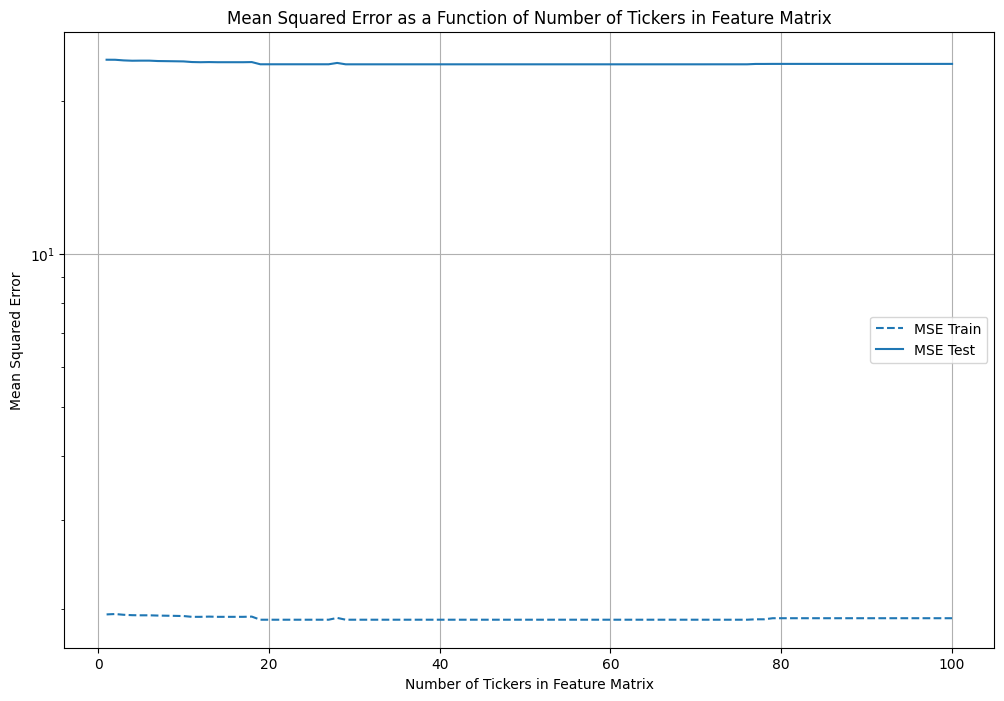

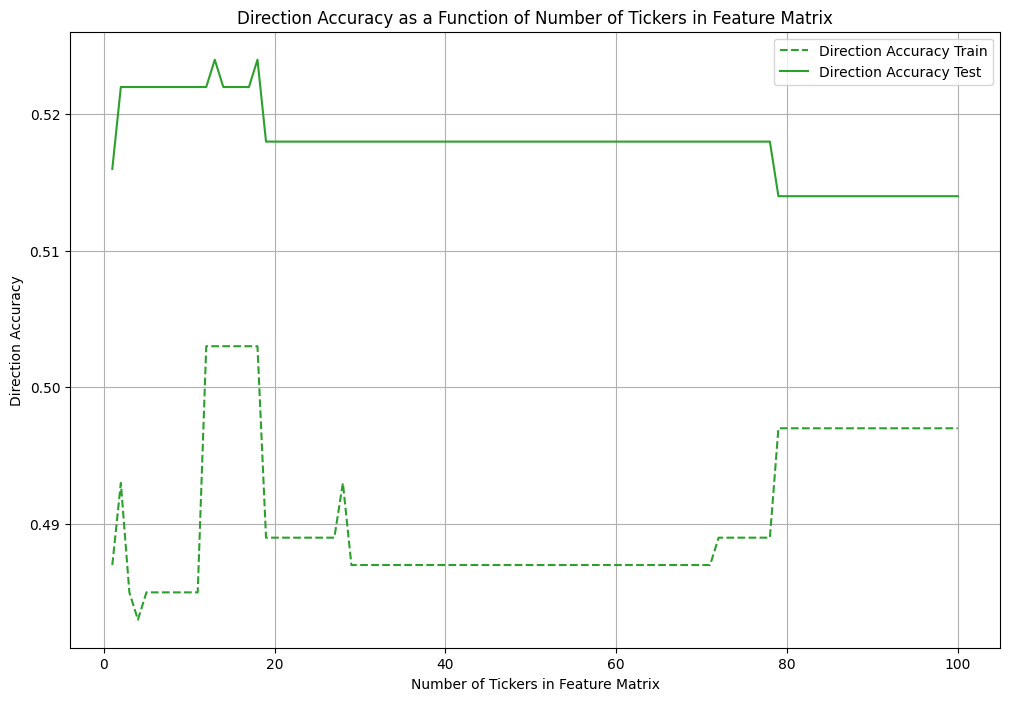

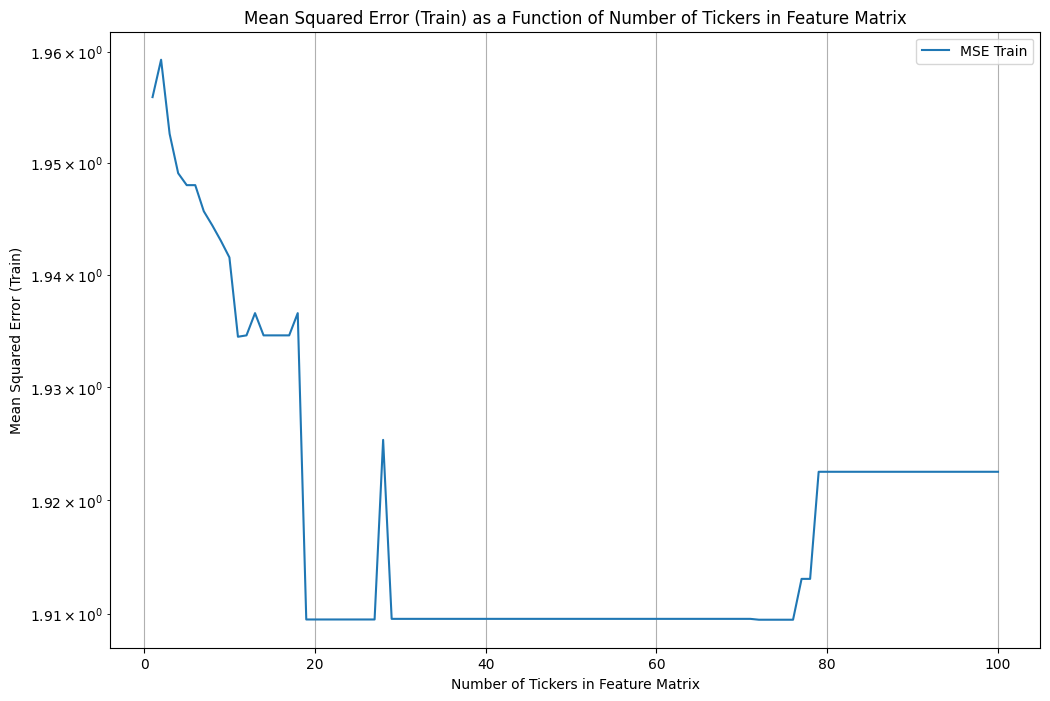

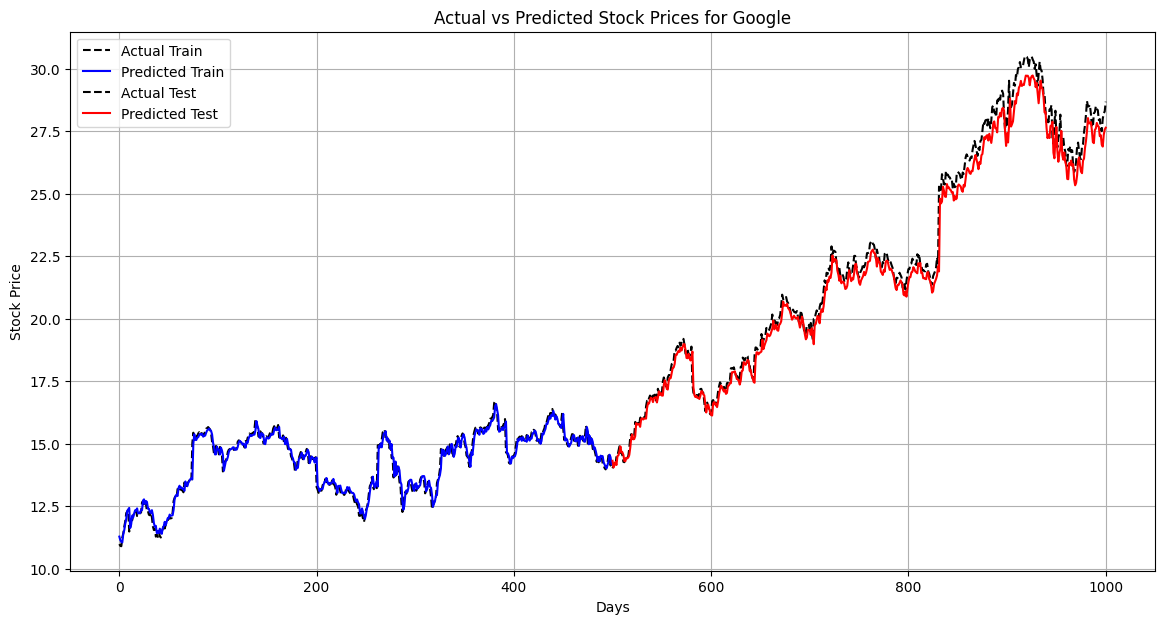

In [8]:
# Convert results to DataFrame
if results:
    results_df = pd.DataFrame(results)
    print("Results DataFrame Head:", results_df.head())

    # Save final results
    results_df.to_csv('final_results.csv', index=False)

    # Display the DataFrame in a Jupyter notebook environment
    display(results_df)

    # Plot Mean Squared Errors (MSE)
    plt.figure(figsize=(12, 8))
    plt.plot(results_df['Num_Tickers'], results_df['MSE_Train'], label='MSE Train', color='tab:blue', linestyle='dashed')
    plt.plot(results_df['Num_Tickers'], results_df['MSE_Test'], label='MSE Test', color='tab:blue', linestyle='solid')
    plt.xlabel('Number of Tickers in Feature Matrix')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error as a Function of Number of Tickers in Feature Matrix')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.show()

    # Plot Direction Accuracy
    plt.figure(figsize=(12, 8))
    plt.plot(results_df['Num_Tickers'], results_df['Direction_Accuracy_Train'], label='Direction Accuracy Train', color='tab:green', linestyle='dashed')
    plt.plot(results_df['Num_Tickers'], results_df['Direction_Accuracy_Test'], label='Direction Accuracy Test', color='tab:green', linestyle='solid')
    plt.xlabel('Number of Tickers in Feature Matrix')
    plt.ylabel('Direction Accuracy')
    plt.title('Direction Accuracy as a Function of Number of Tickers in Feature Matrix')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot only MSE Train
    plt.figure(figsize=(12, 8))
    plt.plot(results_df['Num_Tickers'], results_df['MSE_Train'], label='MSE Train', color='tab:blue')
    plt.xlabel('Number of Tickers in Feature Matrix')
    plt.ylabel('Mean Squared Error (Train)')
    plt.title('Mean Squared Error (Train) as a Function of Number of Tickers in Feature Matrix')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.show()

    # Function to plot actual vs predicted stock prices for Google
    def plot_actual_vs_predicted(predictions):
        plt.figure(figsize=(14, 7))
        plt.plot(predictions['y_train'], label='Actual Train', color='black', linestyle='dashed')
        plt.plot(predictions['predicted_train'], label='Predicted Train', color='blue')
        plt.plot(range(len(predictions['y_train']), len(predictions['y_train']) + len(predictions['y_test'])), predictions['y_test'], label='Actual Test', color='black', linestyle='dashed')
        plt.plot(range(len(predictions['y_train']), len(predictions['y_train']) + len(predictions['y_test'])), predictions['predicted_test'], label='Predicted Test', color='red')
        plt.xlabel('Days')
        plt.ylabel('Stock Price')
        plt.title('Actual vs Predicted Stock Prices for Google')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot the actual vs predicted stock prices for Google using the last evaluated model
    plot_actual_vs_predicted(results[-1]['Predictions'])
else:
    print("No results to display.")
